In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import tensorflow as tf

In [2]:
df_train=pd.read_csv("mitbih_train.csv",header=None)
df_test=pd.read_csv("mitbih_test.csv",header=None)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df_train[187].value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

## Visualize the training dataset

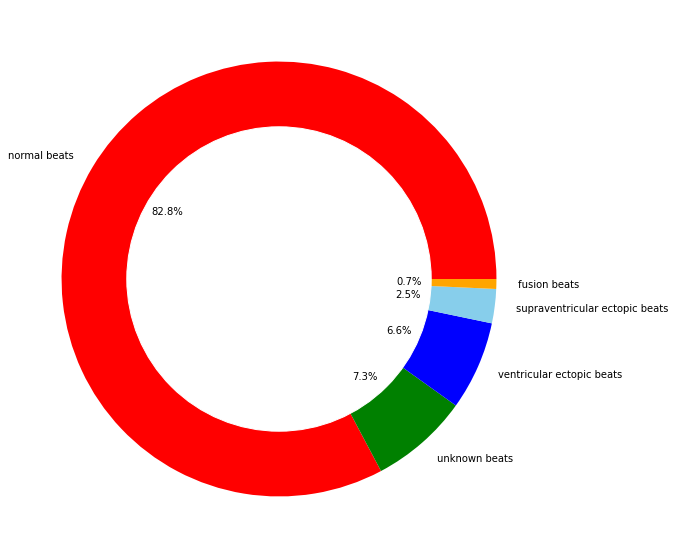

In [4]:
per_class=df_train[187].value_counts()
plt.figure(figsize=(10,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['normal beats','unknown beats','ventricular ectopic beats','supraventricular ectopic beats',
                           'fusion beats'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## Resample 20000 normal beat because they are the majority

In [5]:
from sklearn.utils import resample

d1=df_train[df_train[187]==1]
d2=df_train[df_train[187]==2]
d3=df_train[df_train[187]==3]
d4=df_train[df_train[187]==4]

d0=df_train[df_train[187]==0].sample(n=20000,random_state=42)

d1_upsampled=resample(d1,replace=True,n_samples=20000,random_state=123)
d2_upsampled=resample(d2,replace=True,n_samples=20000,random_state=123)
d3_upsampled=resample(d3,replace=True,n_samples=20000,random_state=123)
d4_upsampled=resample(d4,replace=True,n_samples=20000,random_state=123)

df_train=pd.concat([d0,d1_upsampled,d2_upsampled,d3_upsampled,d4_upsampled])

## Visualizing the resampled data

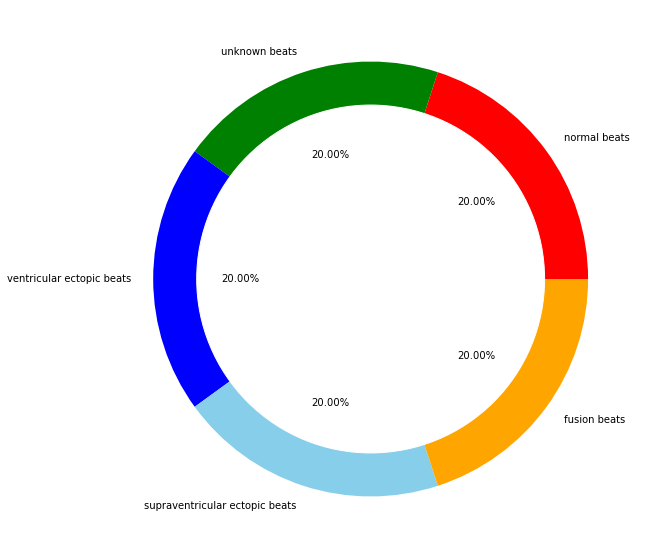

In [6]:
per_class=df_train[187].value_counts()
plt.figure(figsize=(20,10))
circle=plt.Circle( (0,0), 0.8, color='white')
cmap=plt.get_cmap("tab20c")
plt.pie(per_class, labels=['normal beats','unknown beats','ventricular ectopic beats','supraventricular ectopic beats',
                           'fusion beats'], colors=['red','green','blue','skyblue','orange'],autopct='%.2f%%')
p=plt.gcf()
p.gca().add_artist(circle)
plt.show()

In [7]:
classes=df_train.groupby(187,group_keys=False).apply(lambda train:train.sample(1))
categories=["Normal beat","Unknown beats","Ventricular Ectopic beats","Supraventricular Ectopic beats","Fusion beats"]

## Addition of gaussian noise for a more realistic approach

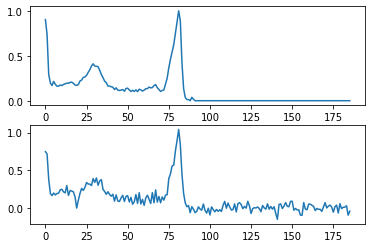

In [8]:
def gaussian_noise(signal):
    noise=np.random.normal(0,0.05,186)
    return(signal+noise)
temp=classes.iloc[0, :186]
bruiter=gaussian_noise(temp)

plt.subplot(2,1,1)
plt.plot(classes.iloc[0, :186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()

## ANN Model

In [ ]:
target_train=df_train[187]
target_test=df_test[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
x_train=df_train.iloc[:,:186].values
x_test=df_test.iloc[:,:186].values
x_train_cnn=x_train.reshape(len(x_train),x_train.shape[1],1)
x_test_cnn=x_test.reshape(len(x_test),x_test.shape[1],1)

model_ann=tf.keras.models.Sequential()
model_ann.add(tf.keras.layers.Dense(20,activation=tf.keras.layers.LeakyReLU(alpha=0.001),input_shape=(186,)))
model_ann.add(tf.keras.layers.Dense(20,activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
model_ann.add(tf.keras.layers.Dense(20,activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
model_ann.add(tf.keras.layers.Dense(20,activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

model_ann.add(tf.keras.layers.Dense(5,activation='softmax'))

model_ann.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
ann_model_history=model_ann.fit(x_train,y_train,epochs=20,batch_size=10,validation_data=(x_test,y_test))

Epoch 1/20
10000/10000 [==============================] - 44s 4ms/step - loss: 0.4889 - accuracy: 0.8179 - val_loss: 0.4748 - val_accuracy: 0.8374
Epoch 2/20
10000/10000 [==============================] - 36s 4ms/step - loss: 0.3183 - accuracy: 0.8813 - val_loss: 0.2997 - val_accuracy: 0.8990
Epoch 3/20
10000/10000 [==============================] - 37s 4ms/step - loss: 0.2637 - accuracy: 0.9025 - val_loss: 0.3824 - val_accuracy: 0.8590
Epoch 4/20
10000/10000 [==============================] - 38s 4ms/step - loss: 0.2296 - accuracy: 0.9169 - val_loss: 0.3116 - val_accuracy: 0.8884
Epoch 5/20
10000/10000 [==============================] - 36s 4ms/step - loss: 0.2092 - accuracy: 0.9248 - val_loss: 0.4075 - val_accuracy: 0.8562
Epoch 6/20
10000/10000 [==============================] - 37s 4ms/step - loss: 0.1929 - accuracy: 0.9315 - val_loss: 0.2945 - val_accuracy: 0.8979
Epoch 7/20
10000/10000 [==============================] - 34s 3ms/step - loss: 0.1822 - accuracy: 0.9353 - val_loss: 0

In [ ]:
model_ann.evaluate(x_test,y_test)

In [ ]:
model_ann.summary()